In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-18 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

* [DRP Austria Covid-19 Hub](https://covid-19-drp-austria.hub.arcgis.com/)
    * [Dashboard](https://experience.arcgis.com/experience/fb603473e1f74f0bbae48155ff238565)
    * [Daten](https://covid-19-drp-austria.hub.arcgis.com/search?categories=covid-19)
        * [COVID19 VERLAUF BUNDESLAND](https://covid-19-drp-austria.hub.arcgis.com/datasets/covid19-verlauf-bundesland?orderBy=genesene&orderByAsc=false)
    * [data.gv.at](https://www.data.gv.at/covid-19/)

In [5]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,173399,154549,7732,593,0,99
2020-05-14,173907,154549,7812,508,0,80
2020-05-15,174321,154549,7895,414,0,83
2020-05-16,174593,154549,7935,272,0,40
2020-05-17,174687,154548,7957,94,-1,22


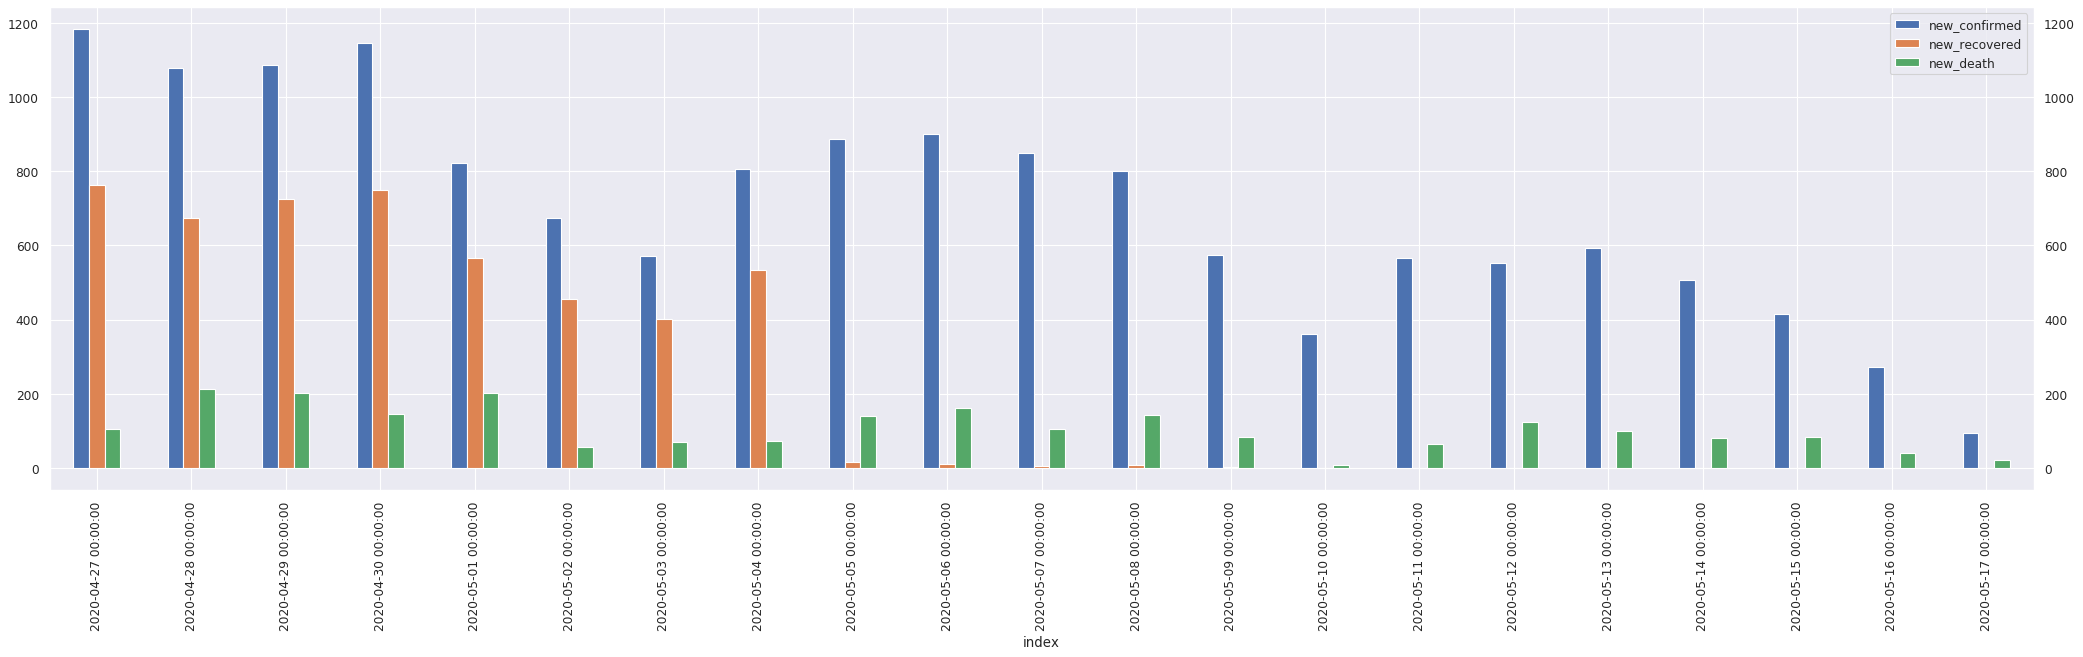

In [6]:
cbr_germany.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 429.36035765346094, max asymptotic: 179556.7529664801; growth-rate: 0.002, date:2020-06-08 00:00:00, projected value: 92.603287951596


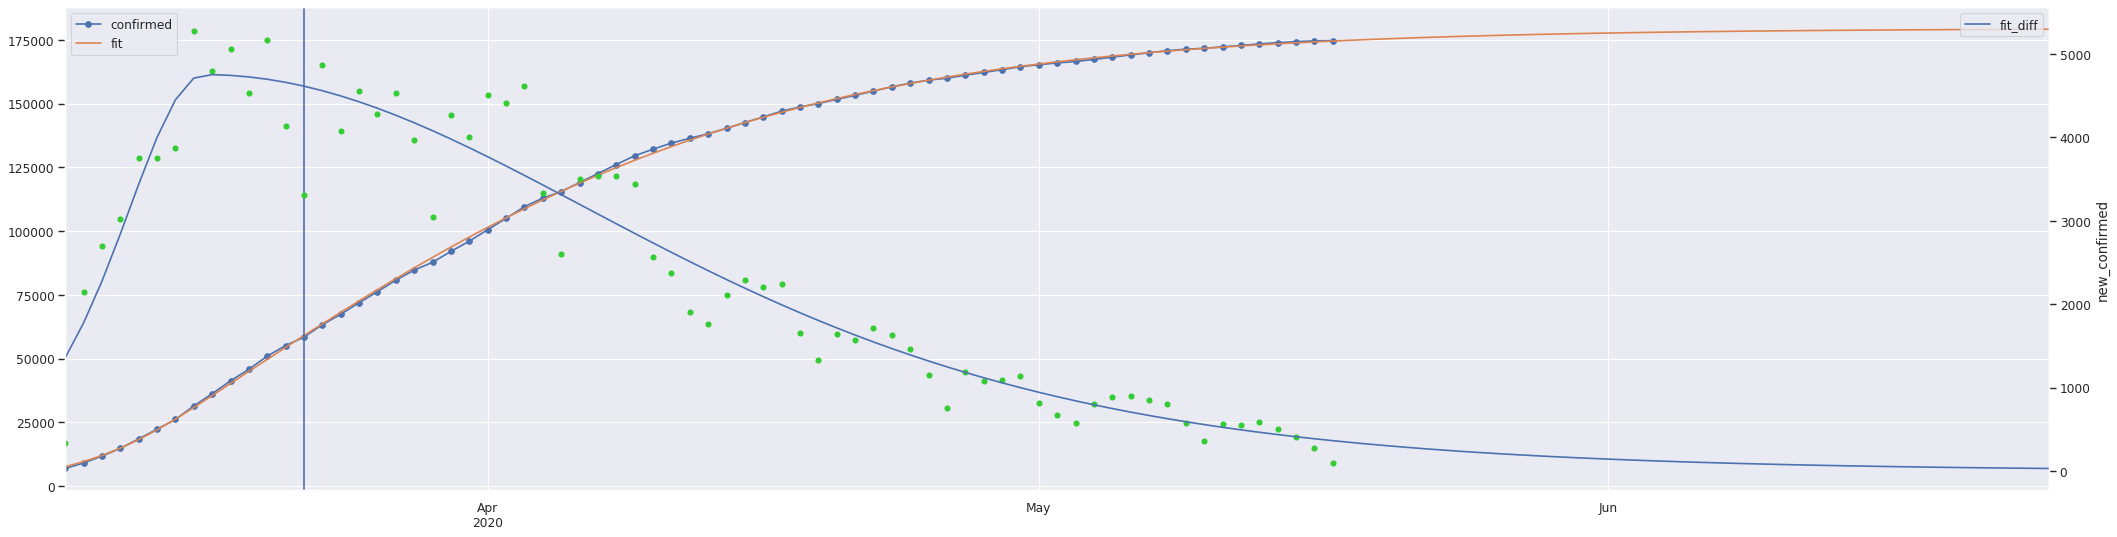

In [7]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [8]:
# country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
# ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add)
# if len(lpopt) == 4:
#     steady_state_rate = lpopt[1] * lpopt[3]
# else:
#     steady_state_rate = 0.0
# print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
# ax.axvline(restriction_start_date);

# ax2 = ax.twinx()
# ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
# lbl = 'confirmed' + '_diff'
# ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


# l = len(ax.get_yticks())
# a1 = ax.get_yticks()[0]
# e1 = ax.get_yticks()[-1]
# a2 = ax2.get_yticks()[0]
# e2 = ax2.get_yticks()[-1]
# ax.set_yticks(np.linspace(a1, e1, l));
# ax2.set_yticks(np.linspace(a2, e2, l));

In [9]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4753.464902


In [10]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-15,0.592,0.49,0.333,0.431,0.504


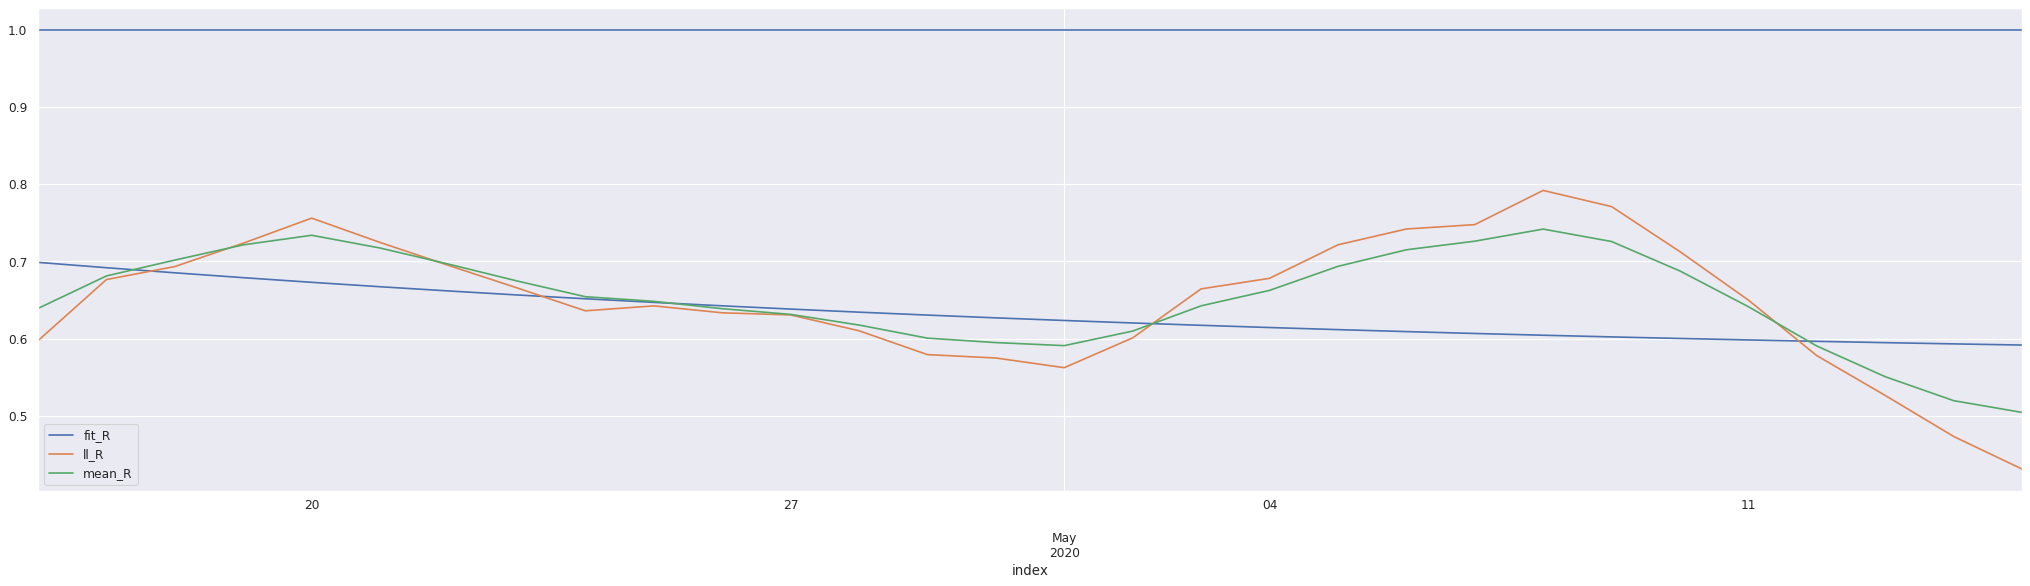

In [11]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [12]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [13]:
df = covid19.get_rki_df(state='Bayern')
cbr_bavaria = covid19.CasesByRegion('Bavaria', df=df)
cbr_bavaria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,45192,40164,2284,117,0,3
2020-05-14,45327,40164,2285,135,0,1
2020-05-15,45423,40164,2286,96,0,1
2020-05-16,45484,40164,2286,61,0,0
2020-05-17,45505,40163,2286,21,-1,0


In [14]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland

bavaria_new_confirmed_threshold = (100.0 * prozent_bayern) // 1 + 1
bavaria_new_confirmed_threshold

16.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 128.93365415159386, max asymptotic: 46072.63270887324; growth-rate: 0.002, date:2020-06-07 00:00:00, projected value: 13.96963340595261


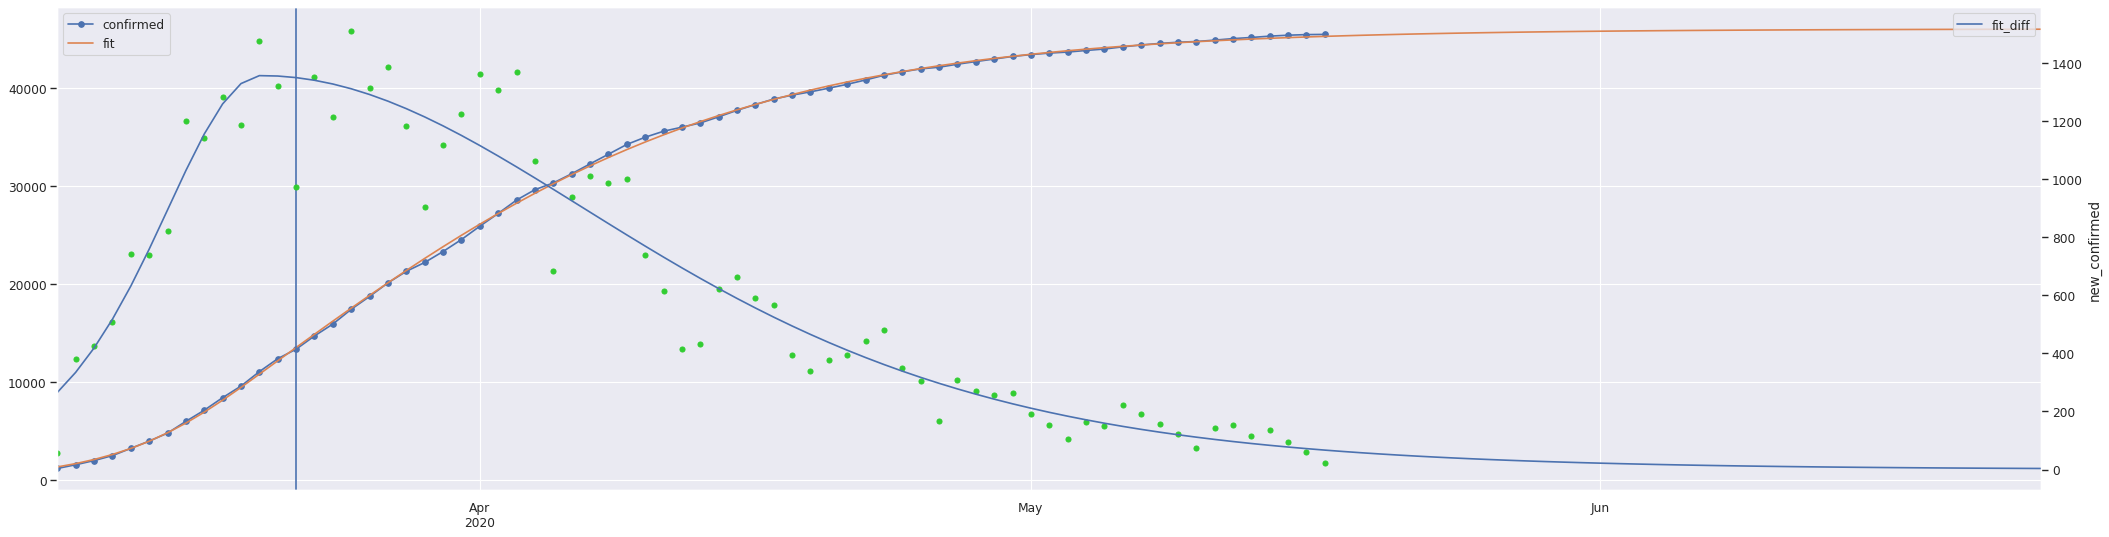

In [15]:
cbr_bavaria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bavaria_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [16]:
cbr_bavaria.calculate_R_estimates()
cbr_bavaria.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-15,0.51,0.73,0.514,0.638,0.626


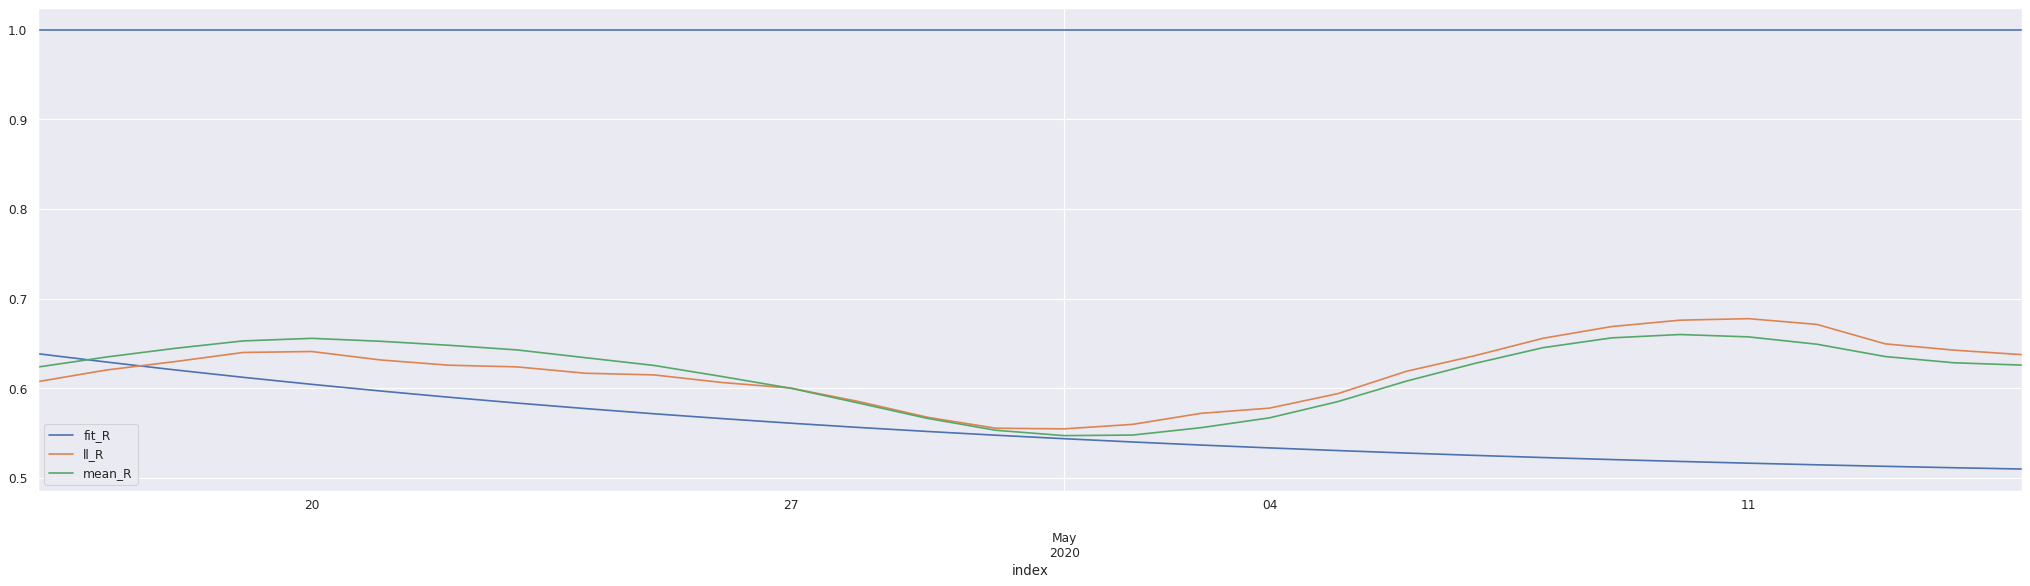

In [17]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [18]:
df = covid19.get_rki_df(state='Nordrhein-Westfalen')
cbr_nrw = covid19.CasesByRegion('NRW', df=df)
cbr_nrw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,35972,32193,1511,148,0,0
2020-05-14,36105,32193,1511,133,0,0
2020-05-15,36237,32193,1512,132,0,1
2020-05-16,36332,32193,1512,95,0,0
2020-05-17,36365,32193,1512,33,0,0


In [19]:
einwohner_nrw      = 17932651.0
prozent_nrw        = einwohner_nrw / einwohner_deutschland

nrw_new_confirmed_threshold = (100.0 * prozent_nrw) // 1 + 1
nrw_new_confirmed_threshold

22.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 98.34918756427774, max asymptotic: 37522.48384715235; growth-rate: 0.003, date:2020-06-13 00:00:00, projected value: 19.91556992763621


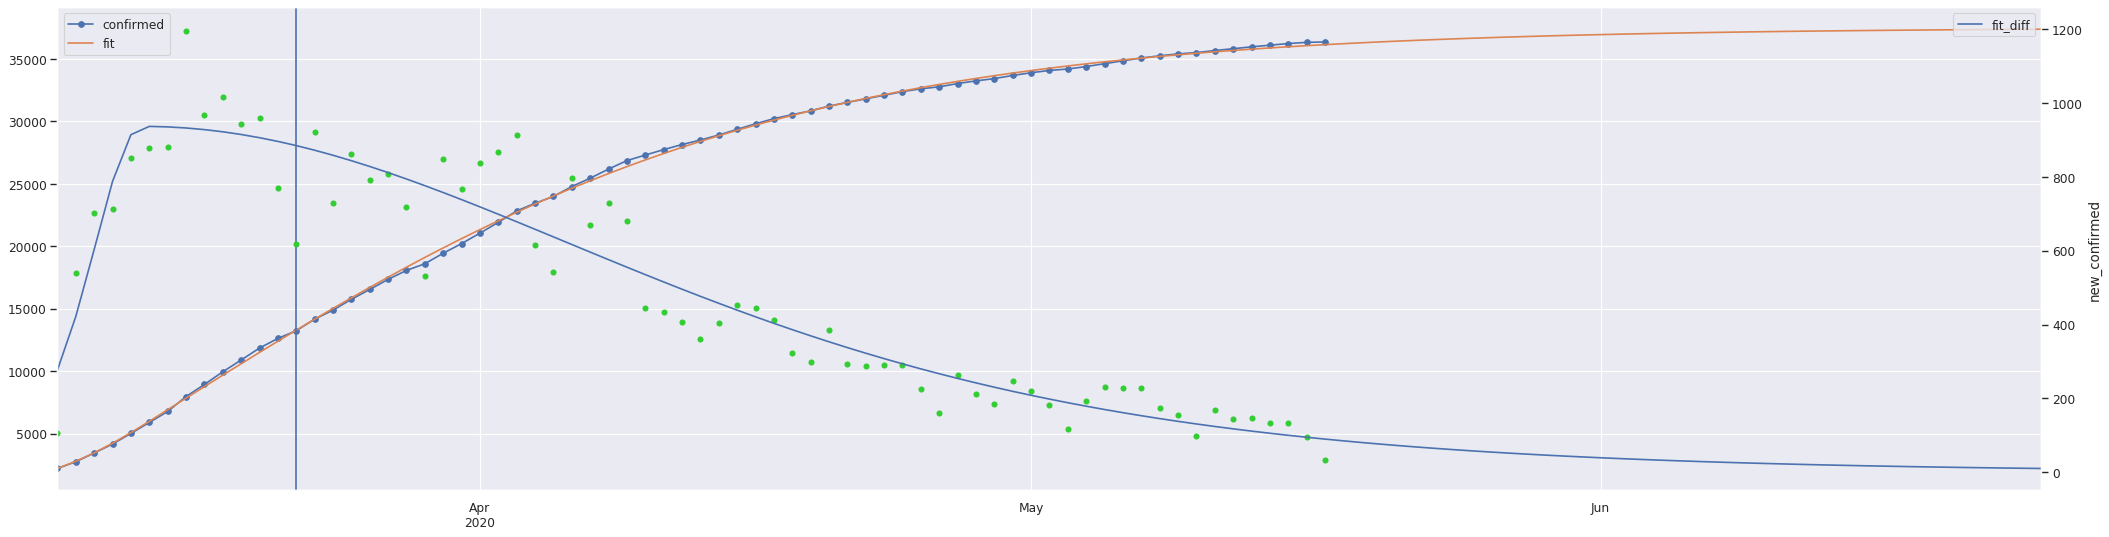

In [20]:
cbr_nrw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=nrw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [21]:
cbr_nrw.calculate_R_estimates()
cbr_nrw.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-15,0.637,0.643,0.622,0.61,0.63


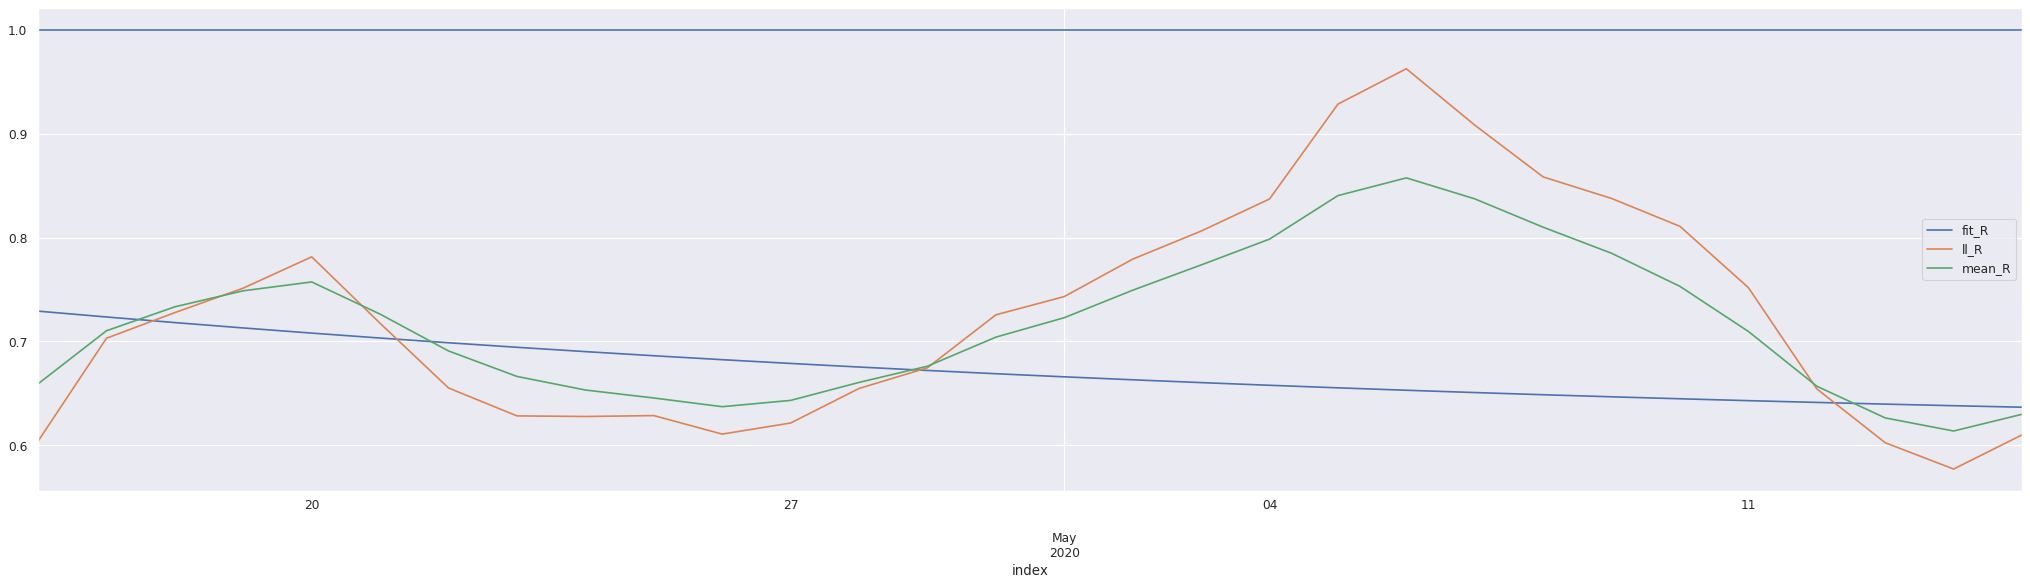

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [23]:
covid19.rki_data_df.Bundesland.unique()

array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen', 'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen'], dtype=object)

In [24]:
df = covid19.get_rki_df(state='Baden-W')
cbr_bw = covid19.CasesByRegion('BW', df=df)
cbr_bw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,33840,30155,1651,104,0,1
2020-05-14,33909,30155,1652,69,0,1
2020-05-15,33955,30155,1652,46,0,0
2020-05-16,33982,30155,1652,27,0,0
2020-05-17,33997,30155,1652,15,0,0


In [25]:
einwohner_bw      = 11069533.0
prozent_bw        = einwohner_bw / einwohner_deutschland

bw_new_confirmed_threshold = (100.0 * prozent_bw) // 1 + 1
bw_new_confirmed_threshold

14.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 88.78913349326167, max asymptotic: 34910.96512329504; growth-rate: 0.002, date:2020-06-10 00:00:00, projected value: 12.45310099386776


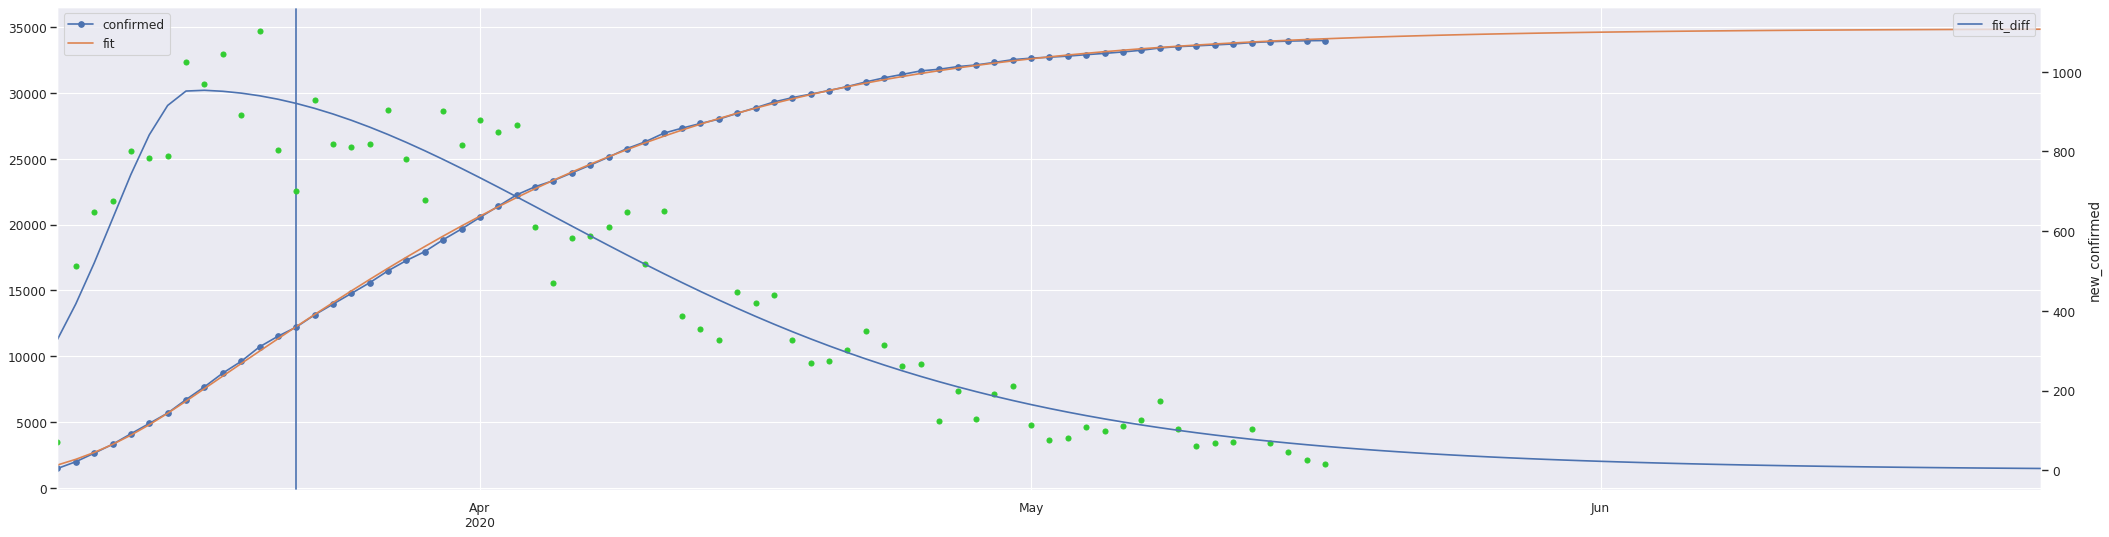

In [26]:
cbr_bw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [27]:
cbr_bw.calculate_R_estimates()
cbr_bw.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-15,0.569,0.125,0.0,0.0,0.231


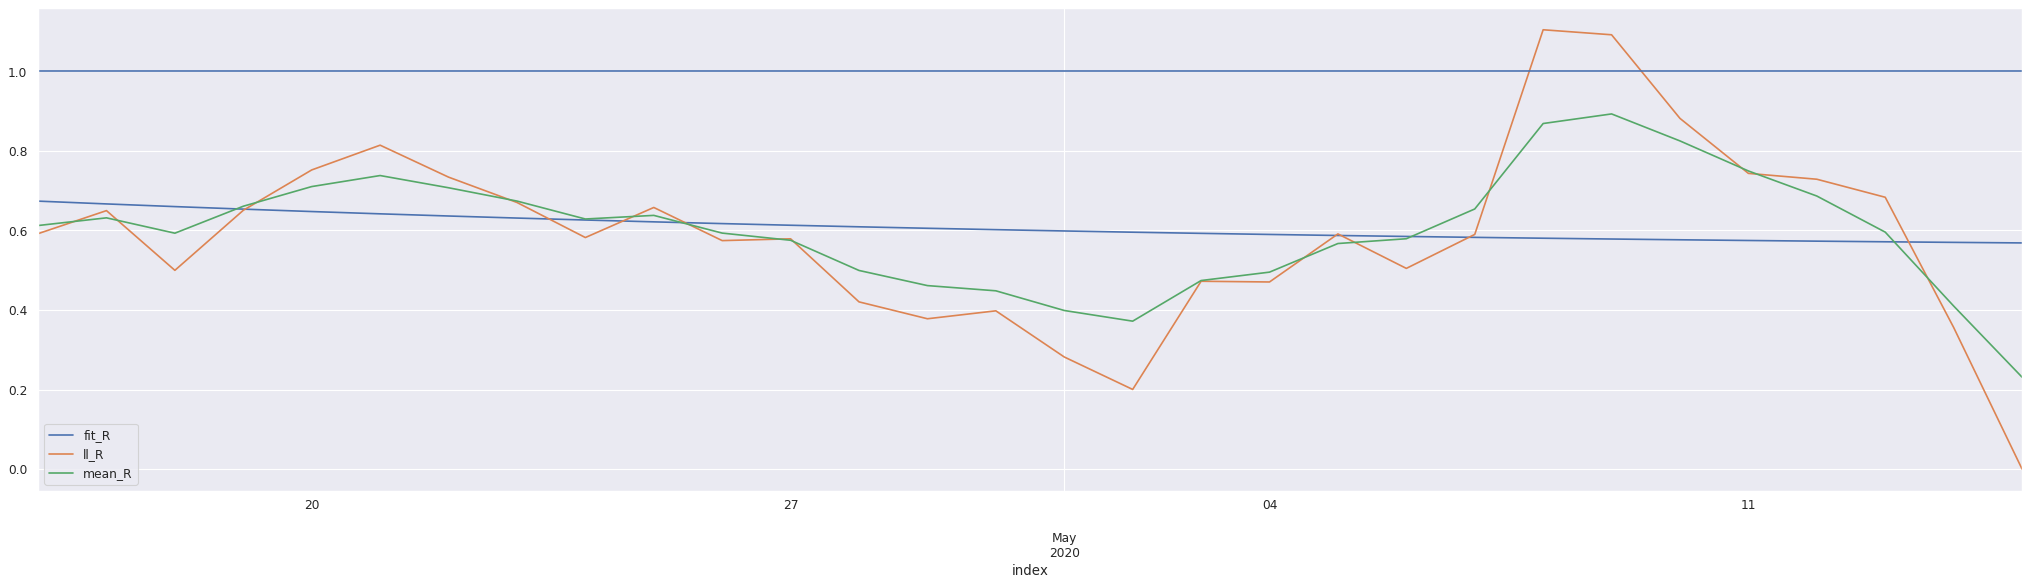

In [28]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [29]:
df = covid19.get_rki_df(county='LK Traunstein')
cbr_traunstein = covid19.CasesByRegion('LK Traunstein', df=df)
cbr_traunstein.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,1269,1089,84,3,0,0
2020-05-14,1271,1089,84,2,0,0
2020-05-15,1272,1089,84,1,0,0
2020-05-16,1272,1089,84,0,0,0
2020-05-17,1272,1089,84,0,0,0


In [30]:
tage_inzidenz = 10

In [31]:
# https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/04-kreise.html
einwohner_lk_traunstein = 177089
einwohner_sk_regensburg = 152610
einwohner_lk_regensburg = 193572

In [32]:
tage_inzidenz_lk_traunstein = cbr_traunstein.df['new_confirmed'][-tage_inzidenz:].sum() 
round(tage_inzidenz_lk_traunstein,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000 * 7,1)

(18, 1.0, 7.1)

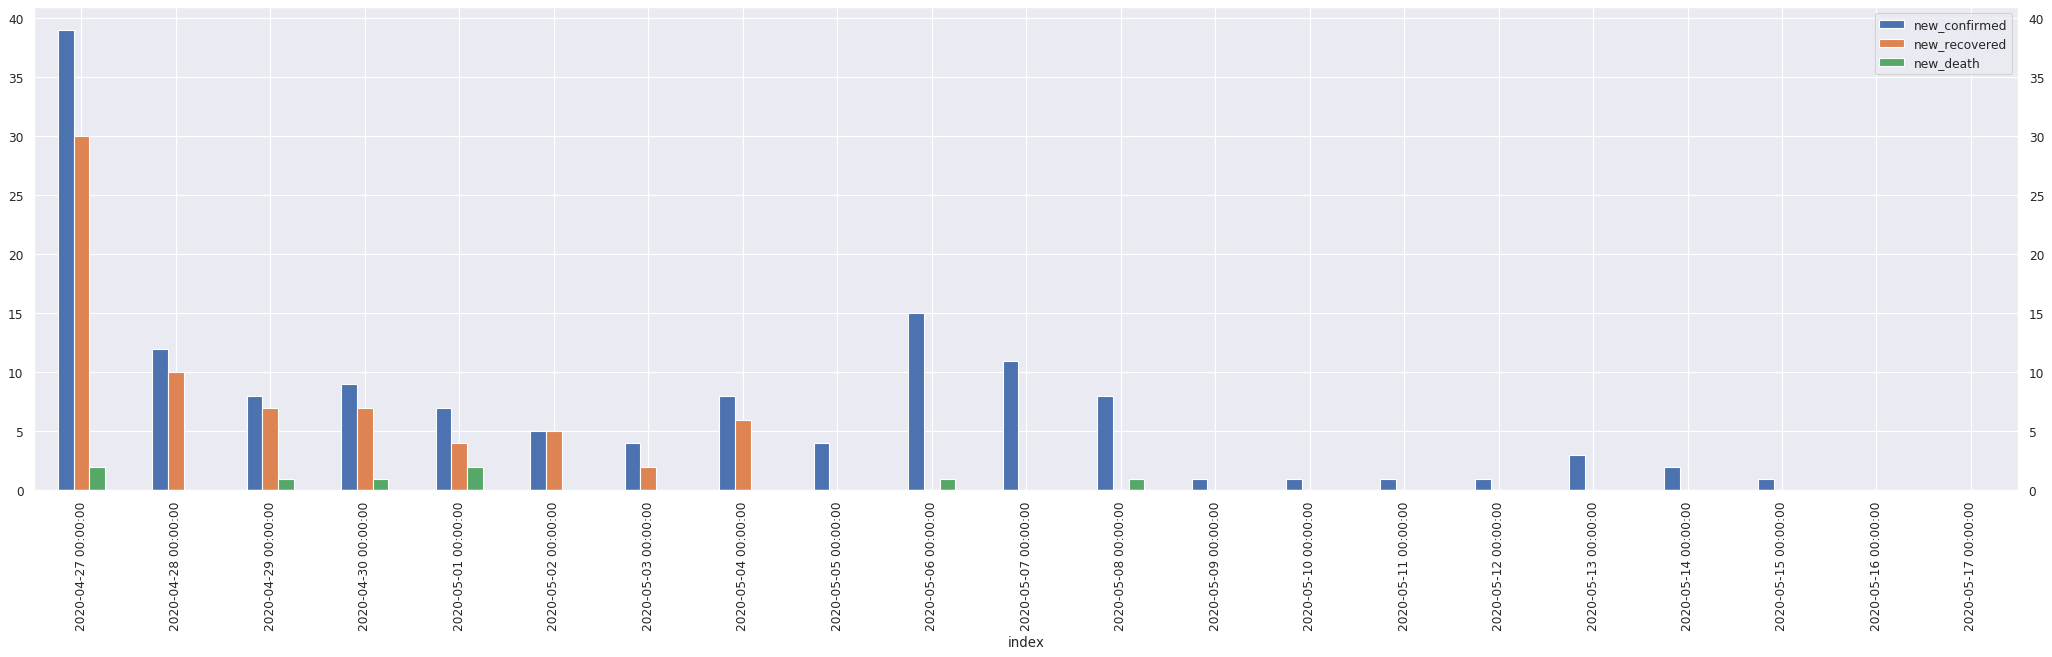

In [33]:
cbr_traunstein.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 7.293246204917578, max asymptotic: 1402.5980057827785; growth-rate: 0.004, date:2020-06-25 00:00:00, projected value: 0.5714486534229862


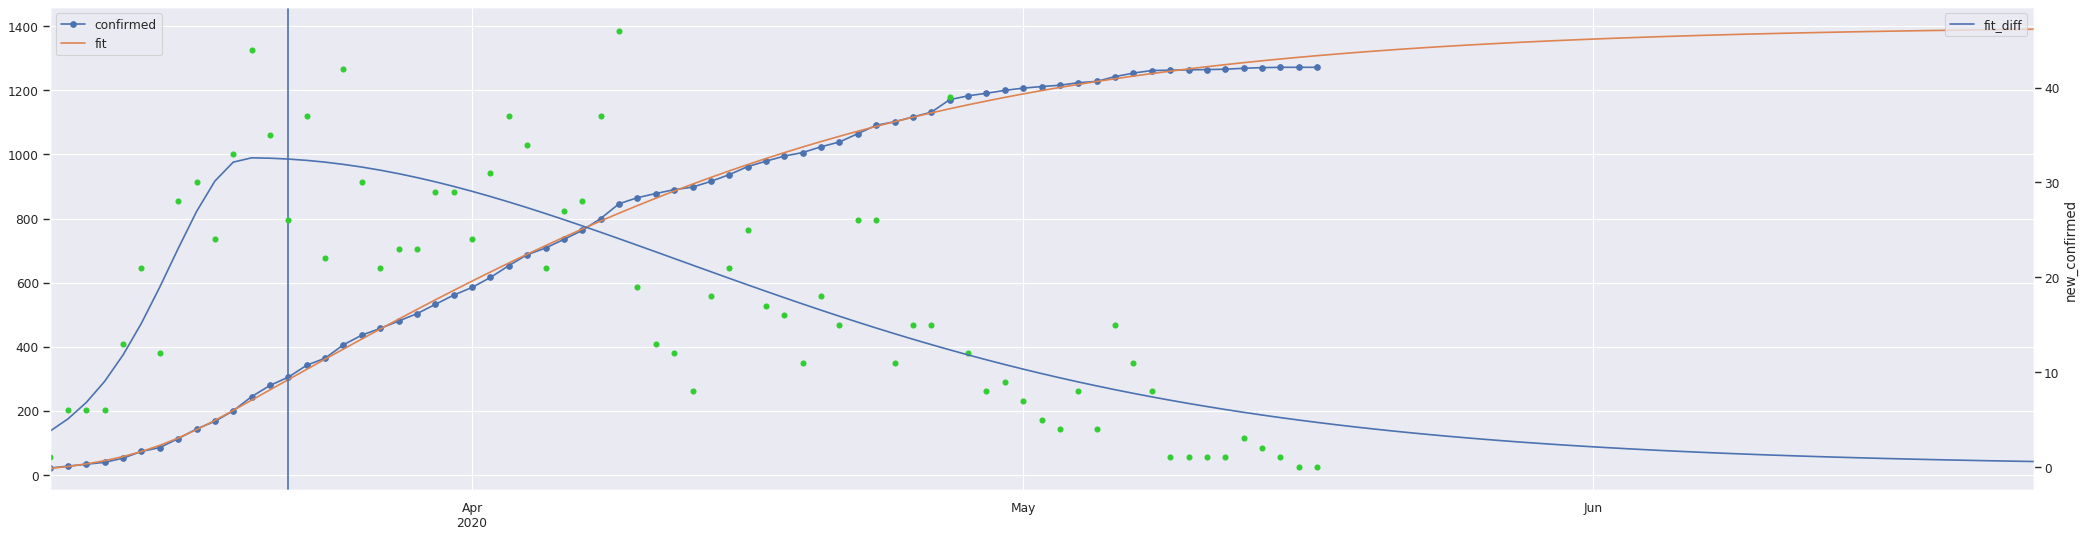

In [34]:
cbr_traunstein.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [35]:
cbr_traunstein.calculate_R_estimates()
cbr_traunstein.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-15,0.658,0.051,0.0,0.0,0.236


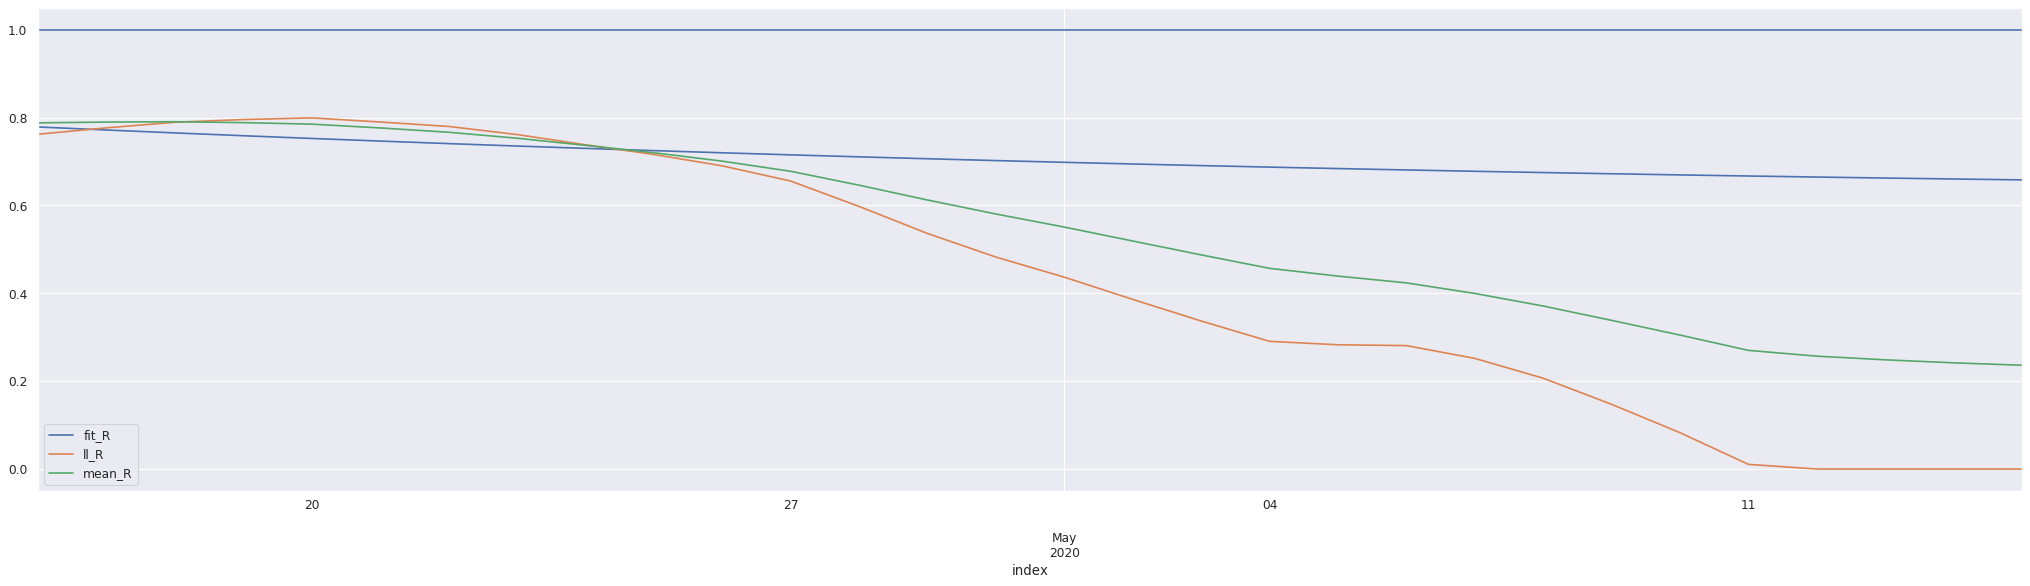

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [37]:
df = covid19.get_rki_df(county='SK Regensburg')
cbr_sk_regensburg = covid19.CasesByRegion('SK Regensburg', df=df)
cbr_sk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,482,445,9,1,0,0
2020-05-14,488,445,9,6,0,0
2020-05-15,489,445,9,1,0,0
2020-05-16,492,445,9,3,0,0
2020-05-17,492,445,9,0,0,0


In [38]:
tage_inzidenz_sk_regensburg = cbr_sk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
round(tage_inzidenz_sk_regensburg,1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000 * 7, 1)

(17, 1.1, 7.8)

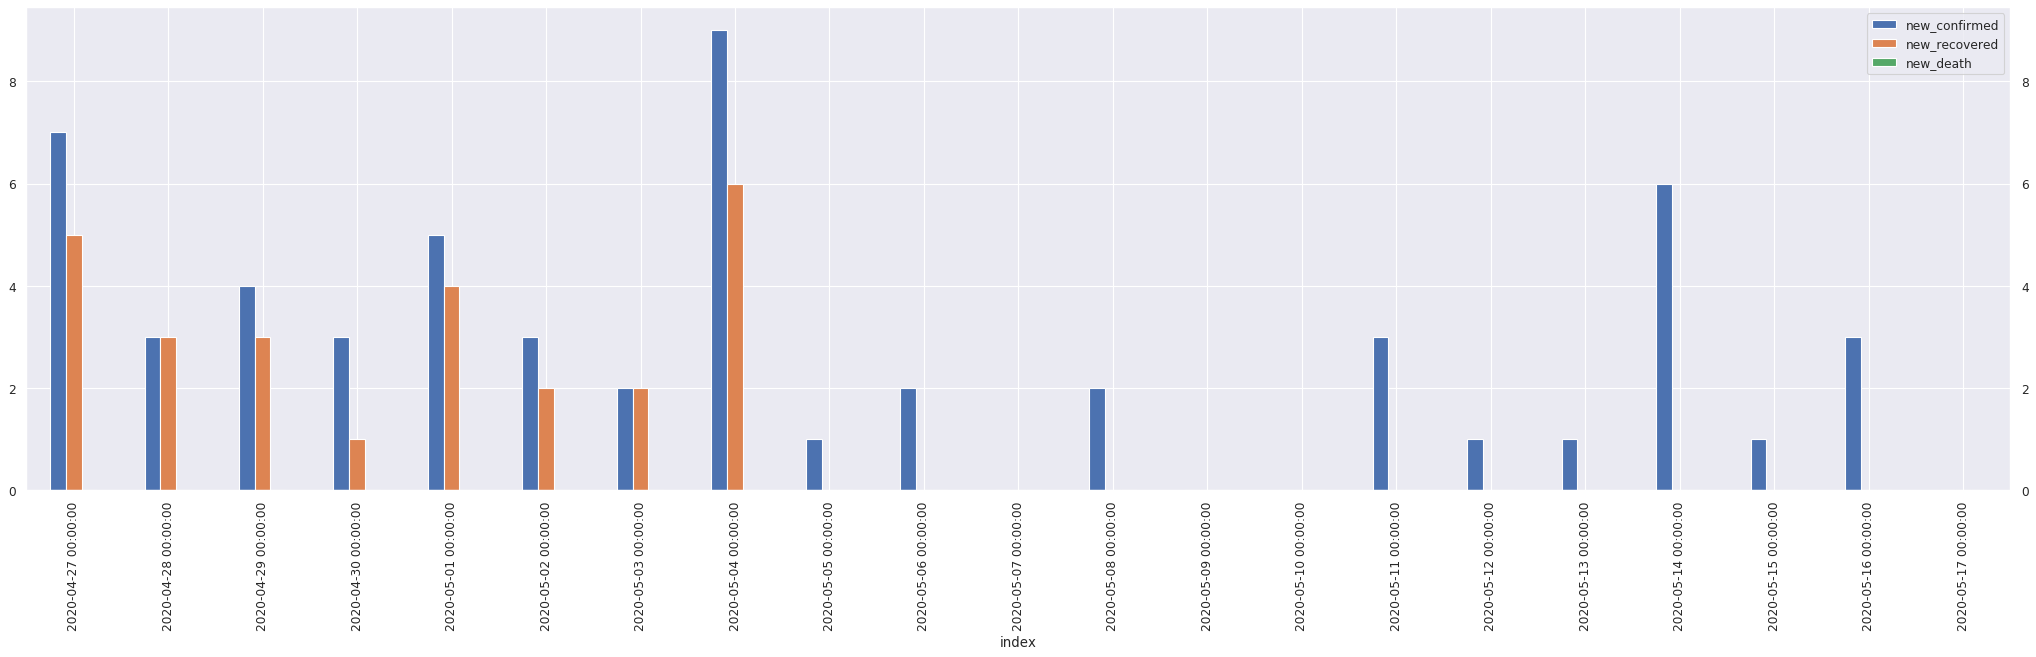

In [39]:
cbr_sk_regensburg.plot_daily_stats()

In [40]:
df = covid19.get_rki_df(county='LK Regensburg')
cbr_lk_regensburg = covid19.CasesByRegion('LK Regensburg', df=df)
cbr_lk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,446,414,14,0,0,0
2020-05-14,448,414,14,2,0,0
2020-05-15,448,414,14,0,0,0
2020-05-16,448,414,14,0,0,0
2020-05-17,449,414,14,1,0,0


In [41]:
tage_inzidenz_lk_regensburg = cbr_lk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
tage_inzidenz_lk_regensburg, round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000 * 7, 1)

(9, 0.5, 3.3)

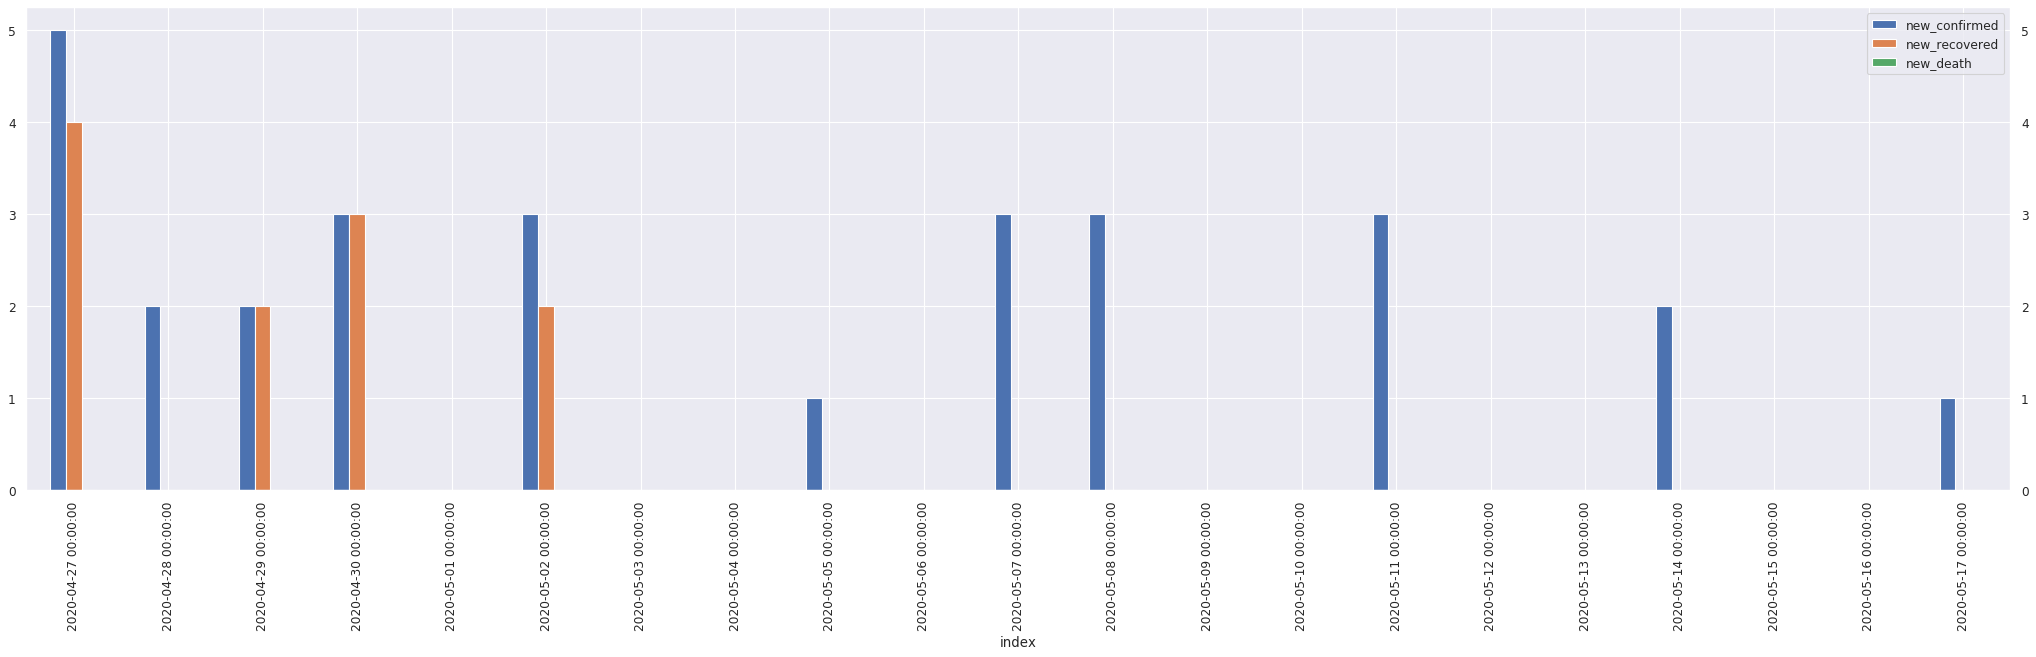

In [42]:
cbr_lk_regensburg.plot_daily_stats()

In [43]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [44]:
df = covid19.get_rki_df(time_anchor_column_name='Meldedatum')
cbr_germany2 = covid19.CasesByRegion('Germany', df=df)
cbr_germany2.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-13,172796,154490,7732,892,52,99
2020-05-14,173587,154529,7812,791,39,80
2020-05-15,174194,154540,7895,607,11,83
2020-05-16,174562,154546,7935,368,6,40
2020-05-17,174687,154548,7957,125,2,22


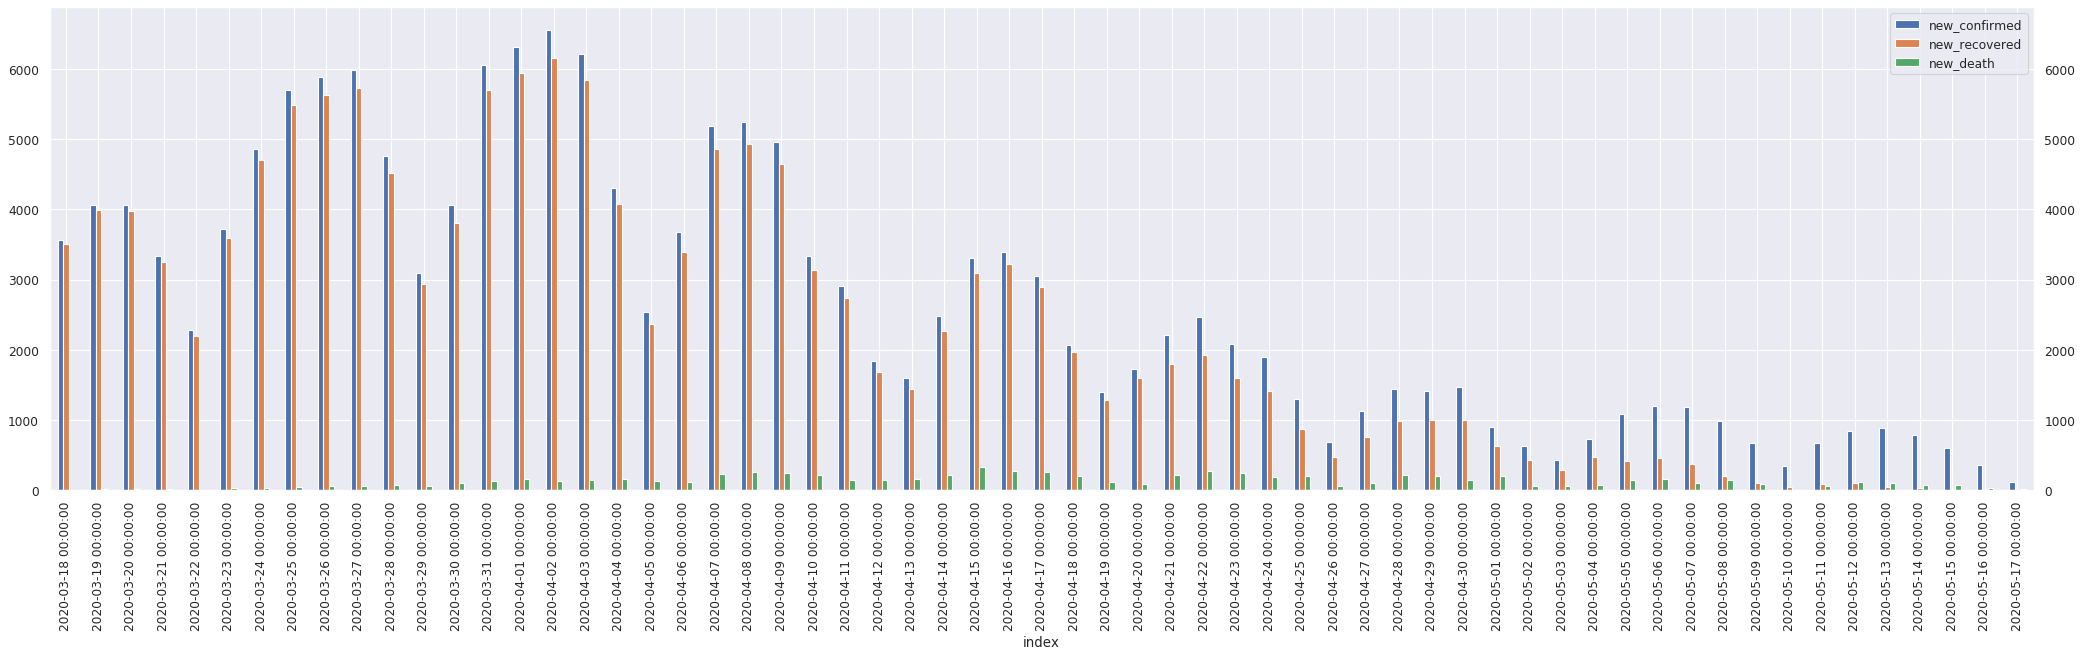

In [45]:
cbr_germany2.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 802.9181788145871; growth-rate: 0.004, date:2020-06-25 00:00:00, projected value: 596.9402520929641


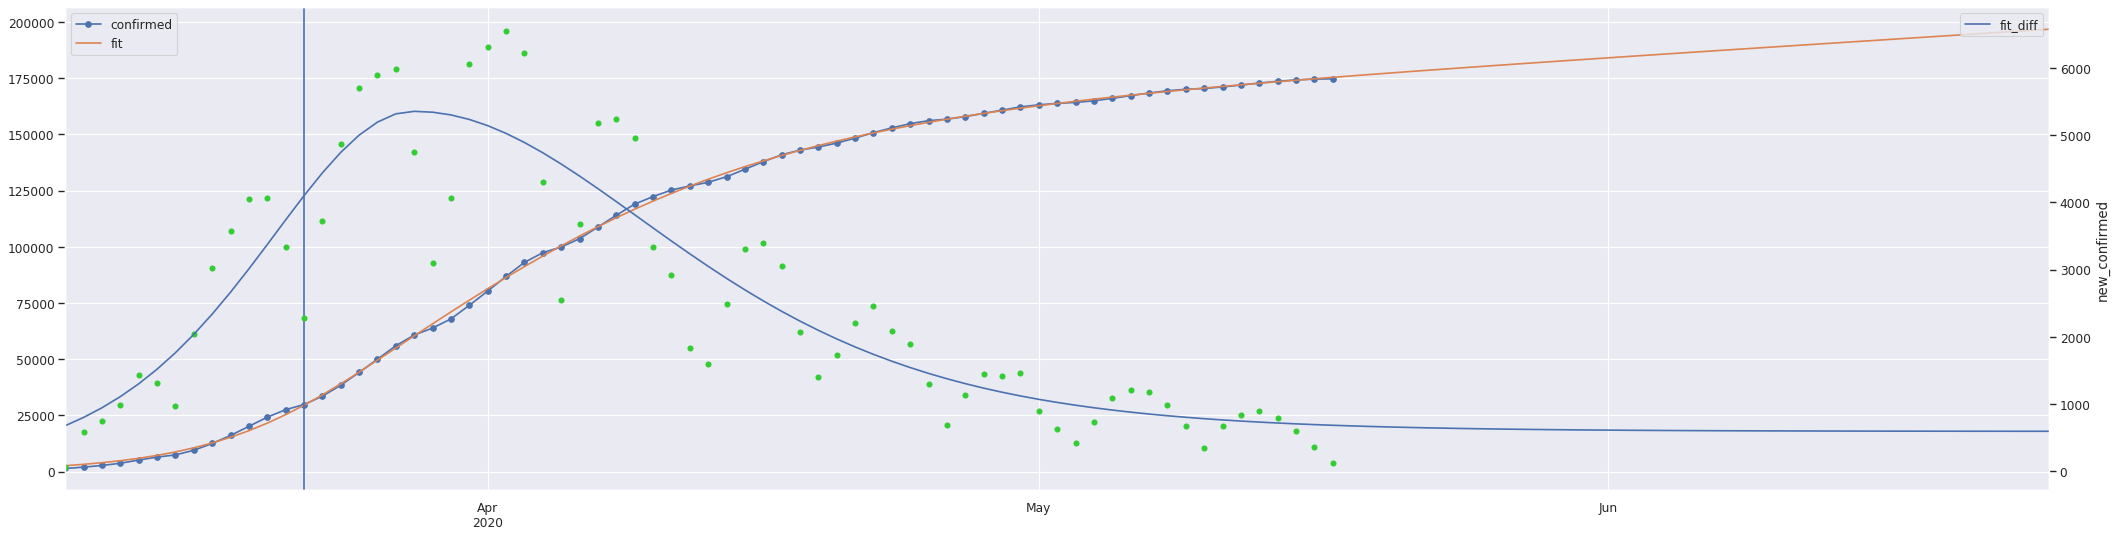

In [46]:
cbr_germany2.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [47]:
cbr_germany2.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5354.715213


In [48]:
cbr_germany2.calculate_R_estimates()
cbr_germany2.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-15,0.843,0.634,0.48,0.595,0.691


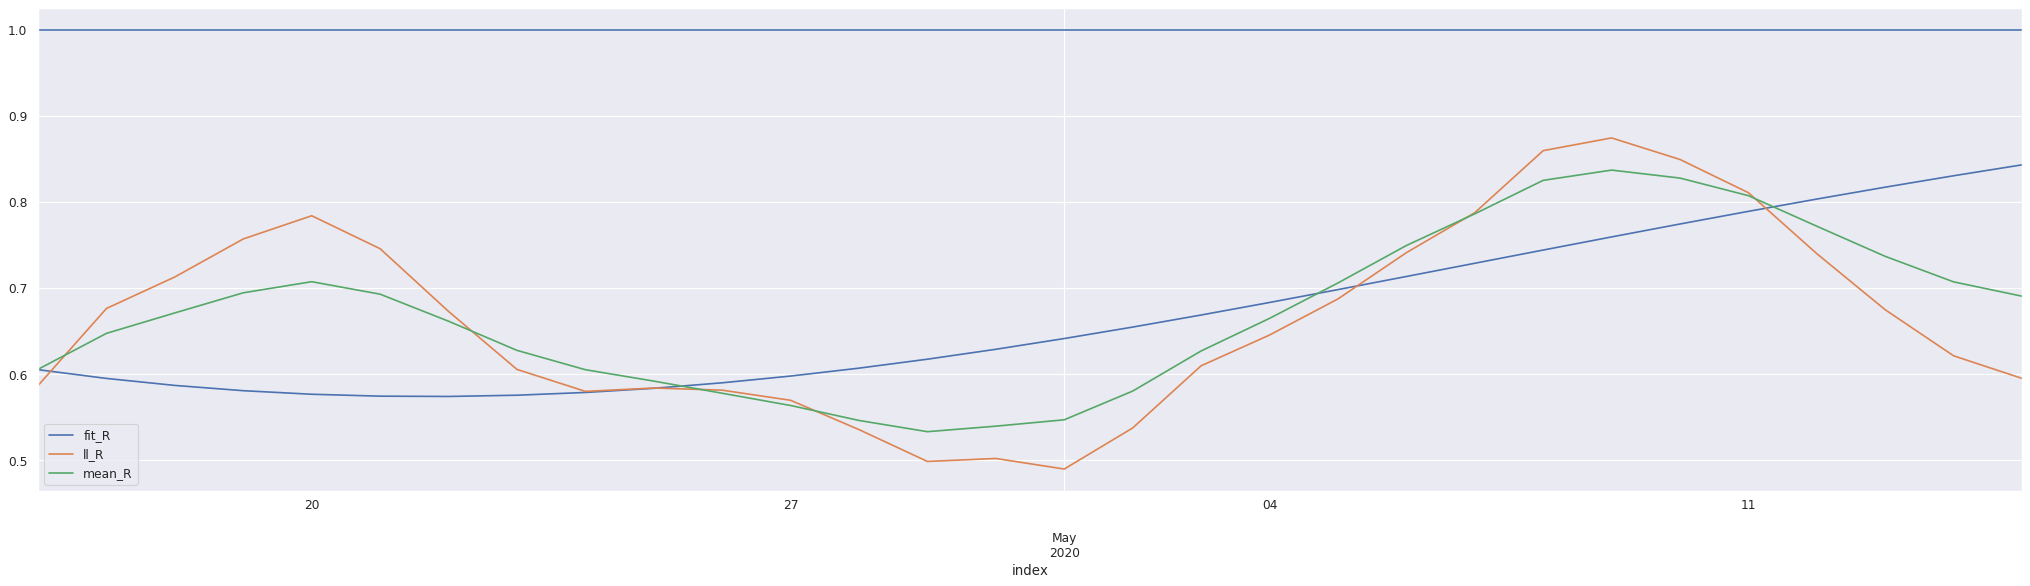

In [49]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [50]:
cbr_germany3 = covid19.CasesByRegion('Germany')
cbr_germany3.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-13,172094,148700,7732,944,1402,99
2020-05-14,172961,150300,7812,867,1600,80
2020-05-15,173716,151597,7895,755,1297,83
2020-05-16,174304,152600,7935,588,1003,40
2020-05-17,174774,154011,7957,470,1411,22


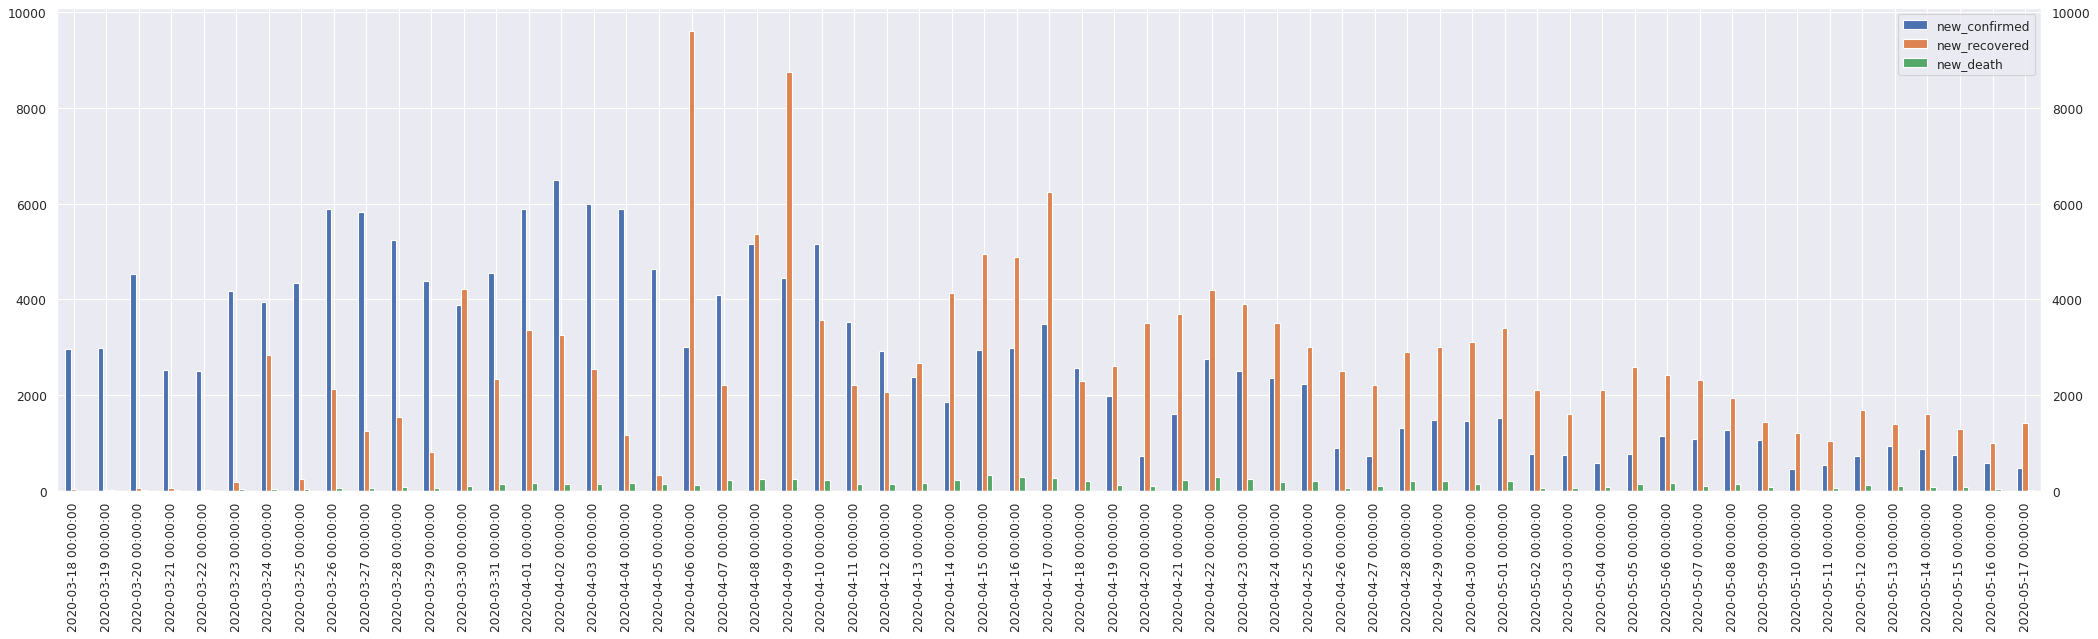

In [51]:
cbr_germany3.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 696.210768588231; growth-rate: 0.004, date:2020-06-25 00:00:00, projected value: 641.6508746070808


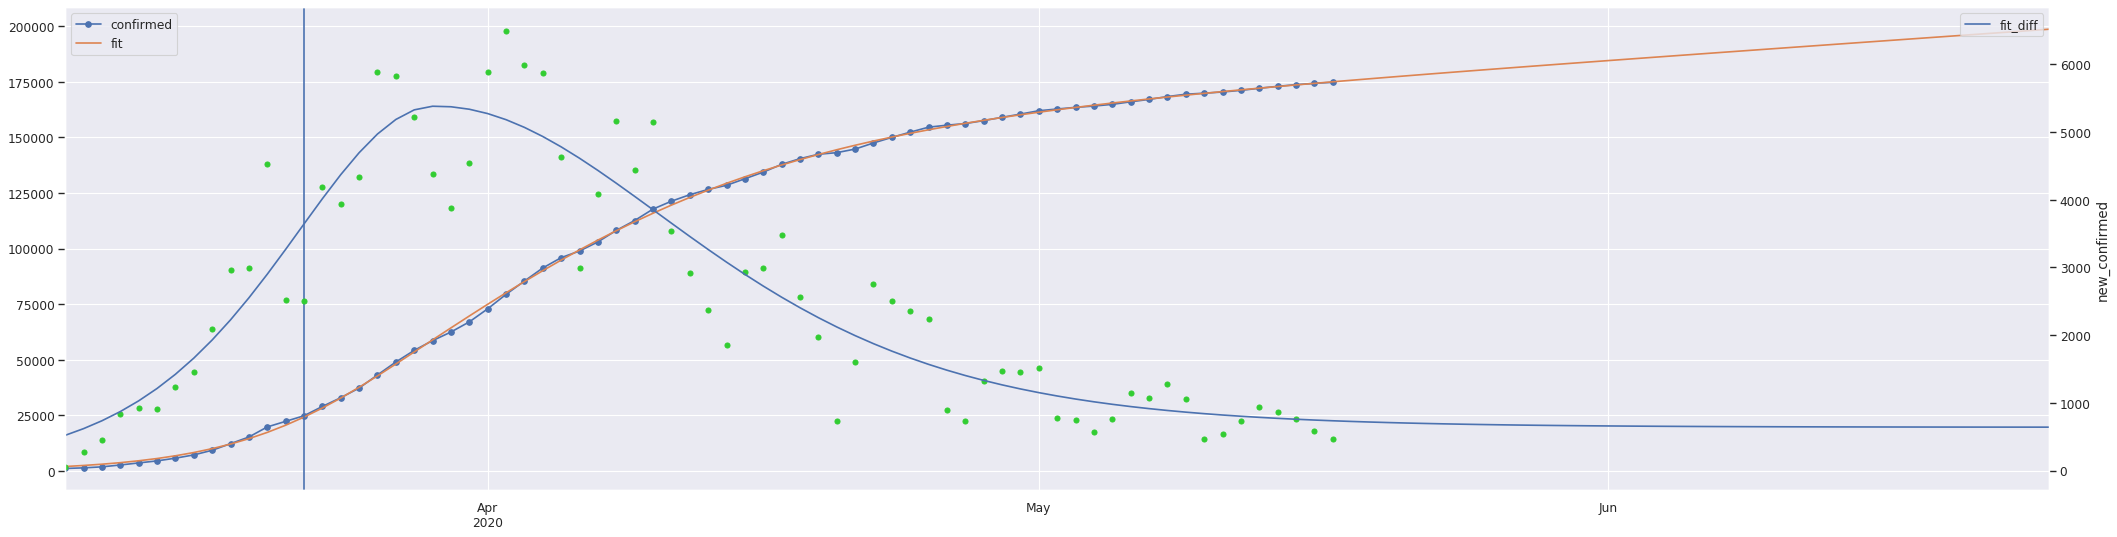

In [52]:
cbr_germany3.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [53]:
cbr_germany3.calculate_R_estimates()
cbr_germany3.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-15,0.843,0.646,0.5,0.716,0.735


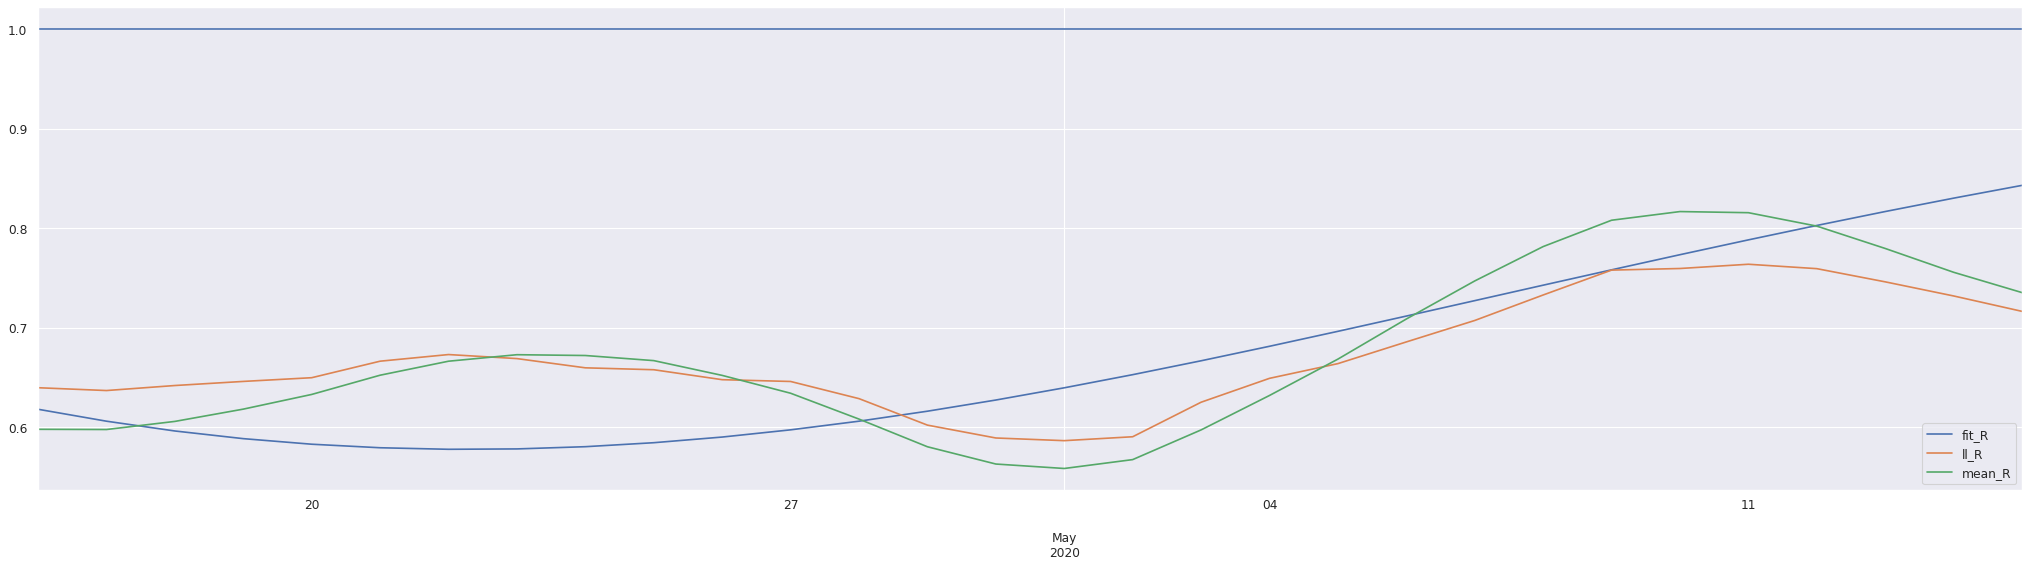

In [54]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [55]:
import requests

In [56]:
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting.html
# rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx'
rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx?__blob=publicationFile'

r = requests.get(rki_nowcasting_data_url, allow_redirects=True)  # to get content after redirection
# r.url, r.content
xd = pd.ExcelFile(r.content)
rki_nowcasting_df_ = xd.parse(xd.sheet_names[-1])
rki_nowcasting_df_.to_excel("rki_nowcasting_data.xlsx") 
rki_nowcasting_df_.tail()

,Datum des Erkrankungsbeginns,Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung),Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glättung),Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glätttung),Punktschätzer der Anzahl Neuerkrankungen,Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Punktschätzer der Reproduktionszahl R,Untere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Obere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Punktschätzer des 7-Tage-R Wertes,Untere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes,Obere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes
68,2020-05-09,634,516,762,712,613,819,0.86,0.80,0.94,0.89,0.85,0.93
69,2020-05-10,581,463,694,658,550,772,0.79,0.72,0.86,0.89,0.83,0.94
70,2020-05-11,723,514,893,655,519,784,0.80,0.70,0.89,0.89,0.81,0.96
71,2020-05-12,736,450,1007,669,486,839,0.88,0.73,1.01,0.87,0.78,0.97
72,2020-05-13,620,365,939,665,448,883,0.94,0.78,1.10,NaN,NaN,NaN


In [57]:
rki_nowcasting_df = rki_nowcasting_df_[['Datum des Erkrankungsbeginns', 'Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung)', 'Punktschätzer der Anzahl Neuerkrankungen']].copy()
rki_nowcasting_df.columns = ['index', 'new_confirmed', 'new_confirmed_']
rki_nowcasting_df['index'] = pd.to_datetime(rki_nowcasting_df['index'])
rki_nowcasting_df = rki_nowcasting_df.set_index('index')

last_date = rki_nowcasting_df.index[-1] + pd.DateOffset(days=1)
last_value = cbr_germany.df['confirmed'].loc[last_date]
# last_date, last_value

ldf = pd.DataFrame(index=rki_nowcasting_df.index)
ldf['confirmed'] = last_value - rki_nowcasting_df['new_confirmed'].values[::-1].cumsum()[::-1]
ldf.loc[last_date] = [last_value]
ldf['recovered'] = 0
ldf['death']     = 0
ldf['new_confirmed'] = covid19.discrete_diff(ldf['confirmed'])
ldf['new_recovered'] = covid19.discrete_diff(ldf['recovered'])
ldf['new_death']     = covid19.discrete_diff(ldf['death'])

rki_nowcasting_df = ldf.copy()

cbr_germany4 = covid19.CasesByRegion('Germany', df=rki_nowcasting_df)
cbr_germany4.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-10,171247,0,0,634.0,0.0,0.0
2020-05-11,171828,0,0,581.0,0.0,0.0
2020-05-12,172551,0,0,723.0,0.0,0.0
2020-05-13,173287,0,0,736.0,0.0,0.0
2020-05-14,173907,0,0,620.0,0.0,0.0


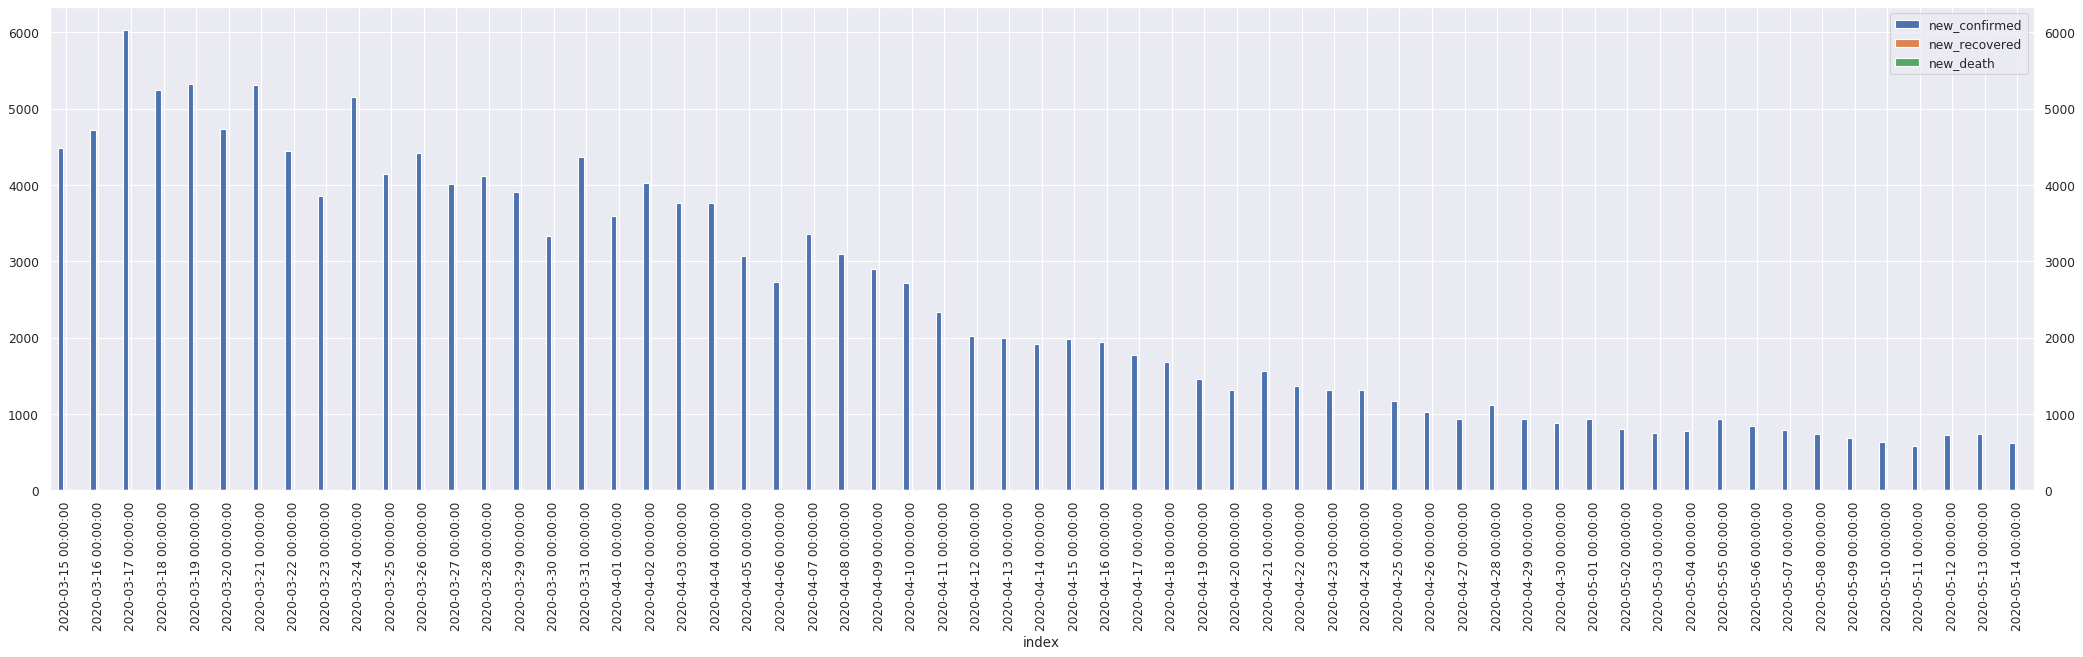

In [58]:
cbr_germany4.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 323.26696736439885; growth-rate: 0.003, date:2020-06-22 00:00:00, projected value: 322.41393086711713


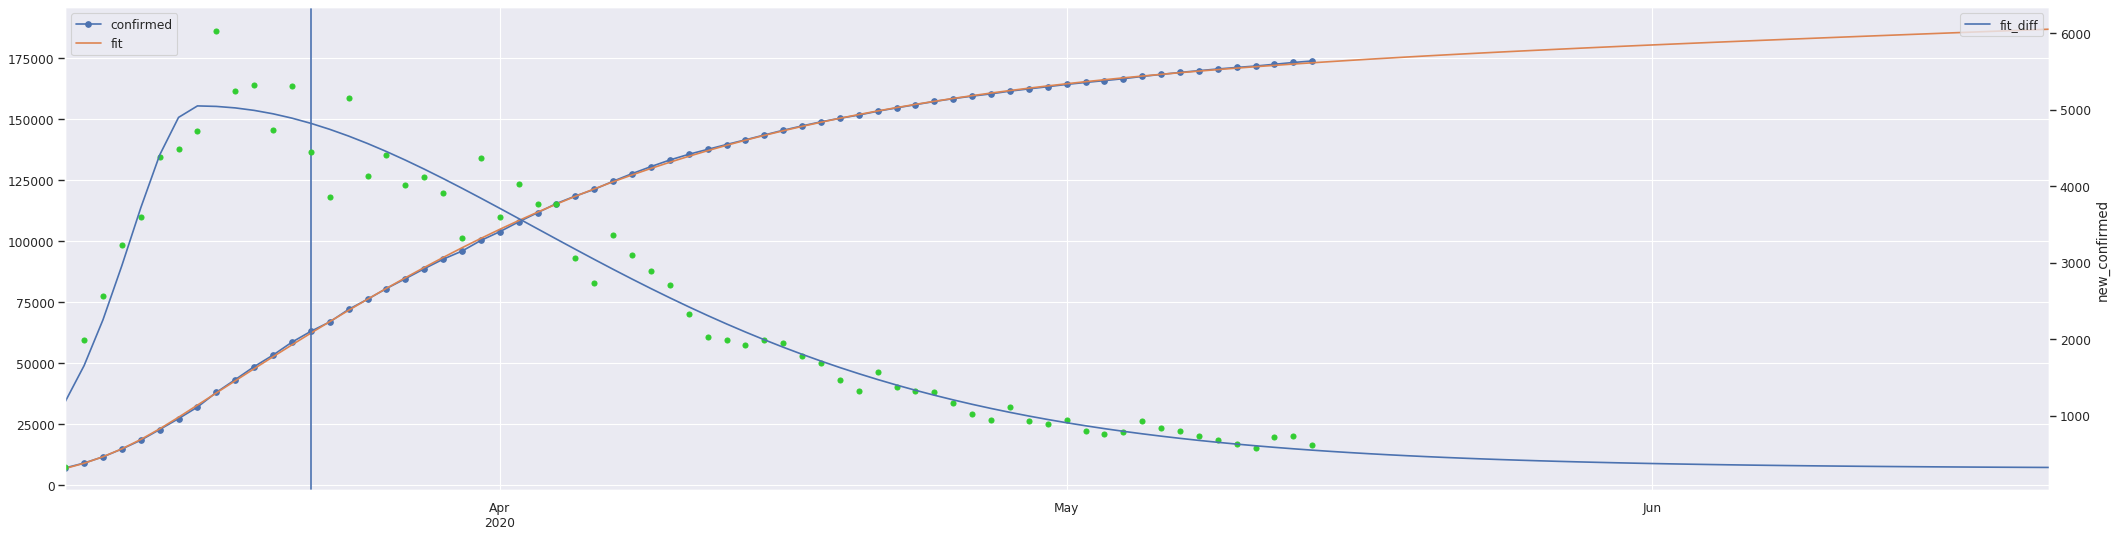

In [59]:
cbr_germany4.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [60]:
cbr_germany4.calculate_R_estimates()
cbr_germany4.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-12,0.74,0.728,0.721,0.722,0.73


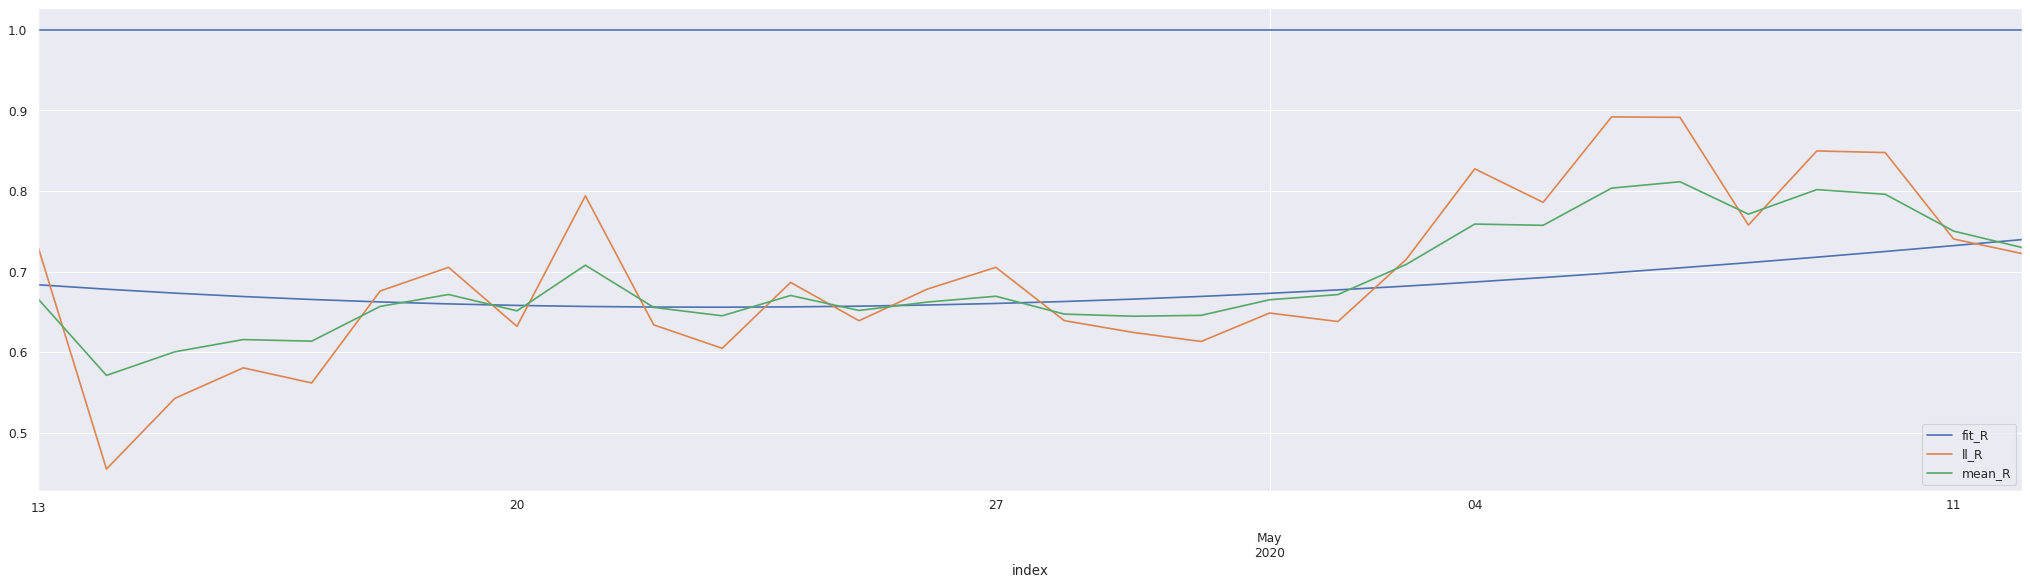

In [61]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [62]:
ldf = cbr_germany.df.loc[cbr_germany4.df.index, ['new_confirmed']]
ldf['new_confirmed_nc'] = cbr_germany4.df['new_confirmed']
ldf['delta'] = ldf['new_confirmed_nc'] - ldf['new_confirmed']
ldf = ldf.astype(np.int)
ldf.iloc[-30:]

,new_confirmed,new_confirmed_nc,delta
index,,,
2020-04-15,2287,1986,-301
2020-04-16,2213,1946,-267
2020-04-17,2247,1778,-469
2020-04-18,1650,1683,33
2020-04-19,1337,1461,124
2020-04-20,1638,1320,-318
2020-04-21,1567,1567,0
2020-04-22,1720,1372,-348
2020-04-23,1626,1318,-308
